In [1]:
import h5py
import os
from matplotlib import image
from matplotlib import pyplot as plt
import re
import numpy as np

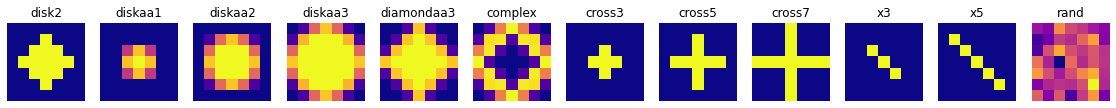

In [2]:
sel_images = os.listdir('out/selems')
plt.subplots(figsize=(200, 200))
for i, sel_image in enumerate(sel_images):
    plt.subplot(1, len(sel_images) * 10, i + 1)
    plt.imshow(image.imread('out/selems/' + sel_image))
    plt.title(sel_image[:-4])
    plt.axis('off')
plt.show()

In [76]:
dnets = [ "pconvnet_double", "lmorphnet_double", "smorphnet_double" ]
snets = [  "pconvnet", "lmorphnet", "smorphnet" ]
nets = { 2: dnets,
         1: snets }
selems = [ "cross3", "cross7", "diskaa2", "diskaa3", "diamondaa3", "complex" ]
dop = { "closing": 1,
        "opening": 0 }
sop = { "erosion": -1,
        "dilation": 1 }
ops = { 1: sop,
        2: dop }

In [80]:
run = 0

plot_params = { "xticks": [],
                "yticks": [] }

max_n_filter = 2 # Maximum number of filters per net
n_padding_column = 2 # Empty plots for clean labeling
global_column_size = max_n_filter + 1 # Number of columns per selem with padding

# Creating list of columns ratios, decreased size for label
# padding columns and spacing columns
width_ratios = np.ones(len(selems) * global_column_size + n_padding_column)
width_ratios[0] /= 2
width_ratios[1] /= 100
width_ratios[n_padding_column + max_n_filter::global_column_size] /= 5

In [50]:
def plot_filters(layer_name, var_name, layers, sel_idx, op, grid, fig, row, n_filters):
        neg_weights = ops[n_filters][op]
        l1_name = [ x for x in layers.keys() if f"{layer_name}1" in x ][0]
        l1 = layers[f"{l1_name}/weights/filter"][()] * (-1 + 2 * neg_weights)
        
        start_column = n_padding_column + global_column_size * sel_idx
        column_size = 1 if n_filters == 2 else 2 

        fig.add_subplot(grid[row, start_column:start_column + column_size], **plot_params)
        plt.imshow(l1.squeeze(), cmap='plasma')
        plt.title(f"{layers[l1_name][f'weights/{var_name}'][()].squeeze():.2f}")#, fontsize=8, y=0.95)
        #plt.subplots_adjust(top=1.15)

        if n_filters == 2:
            l2_name = [ x for x in layers.keys() if f"{layer_name}2" in x ][0]
            l2 = layers[f"{l2_name}/weights/filter"][()] * (1 - 2 * neg_weights)

            fig.add_subplot(grid[row, start_column + 1: start_column + 2], **plot_params)
            plt.imshow(l2.squeeze(), cmap='plasma')
            plt.title(f"{layers[l2_name][f'weights/{var_name}'][()].squeeze():.2f}")#, fontsize=8, y=0.95)
            #plt.subplots_adjust(top=1.15)

In [64]:
def plot_lmorph(**kwargs):
    plot_filters("lm", "p", **kwargs)

def plot_smorph(**kwargs):
    plot_filters("sm", "alpha", **kwargs)

def plot_pconv(**kwargs):
    plot_filters("pconv", "p", **kwargs)

In [313]:
def print_meta(path):
    with h5py.File(f"{path}/vis/meta.h5", "r") as file:
        for key in meta_details:
            print(f"{key + ':':<12} {file[key][()]}")
        print()

In [65]:
meta_details = [ 'batch_size',
                 'dataset',
                 'end_epoch',
                 'end_reason',
                 'loss',
                 'max_epochs',
                 'model',
                 'patience',
                 'sel_name',
                 'sel_size',
                 'vis_freq' ]

net_plots = { "lmorphnet_double": plot_lmorph,
              "pconvnet_double": plot_pconv,
              "smorphnet_double": plot_smorph,
              "lmorphnet": plot_lmorph,
              "pconvnet": plot_pconv,
              "smorphnet": plot_smorph }

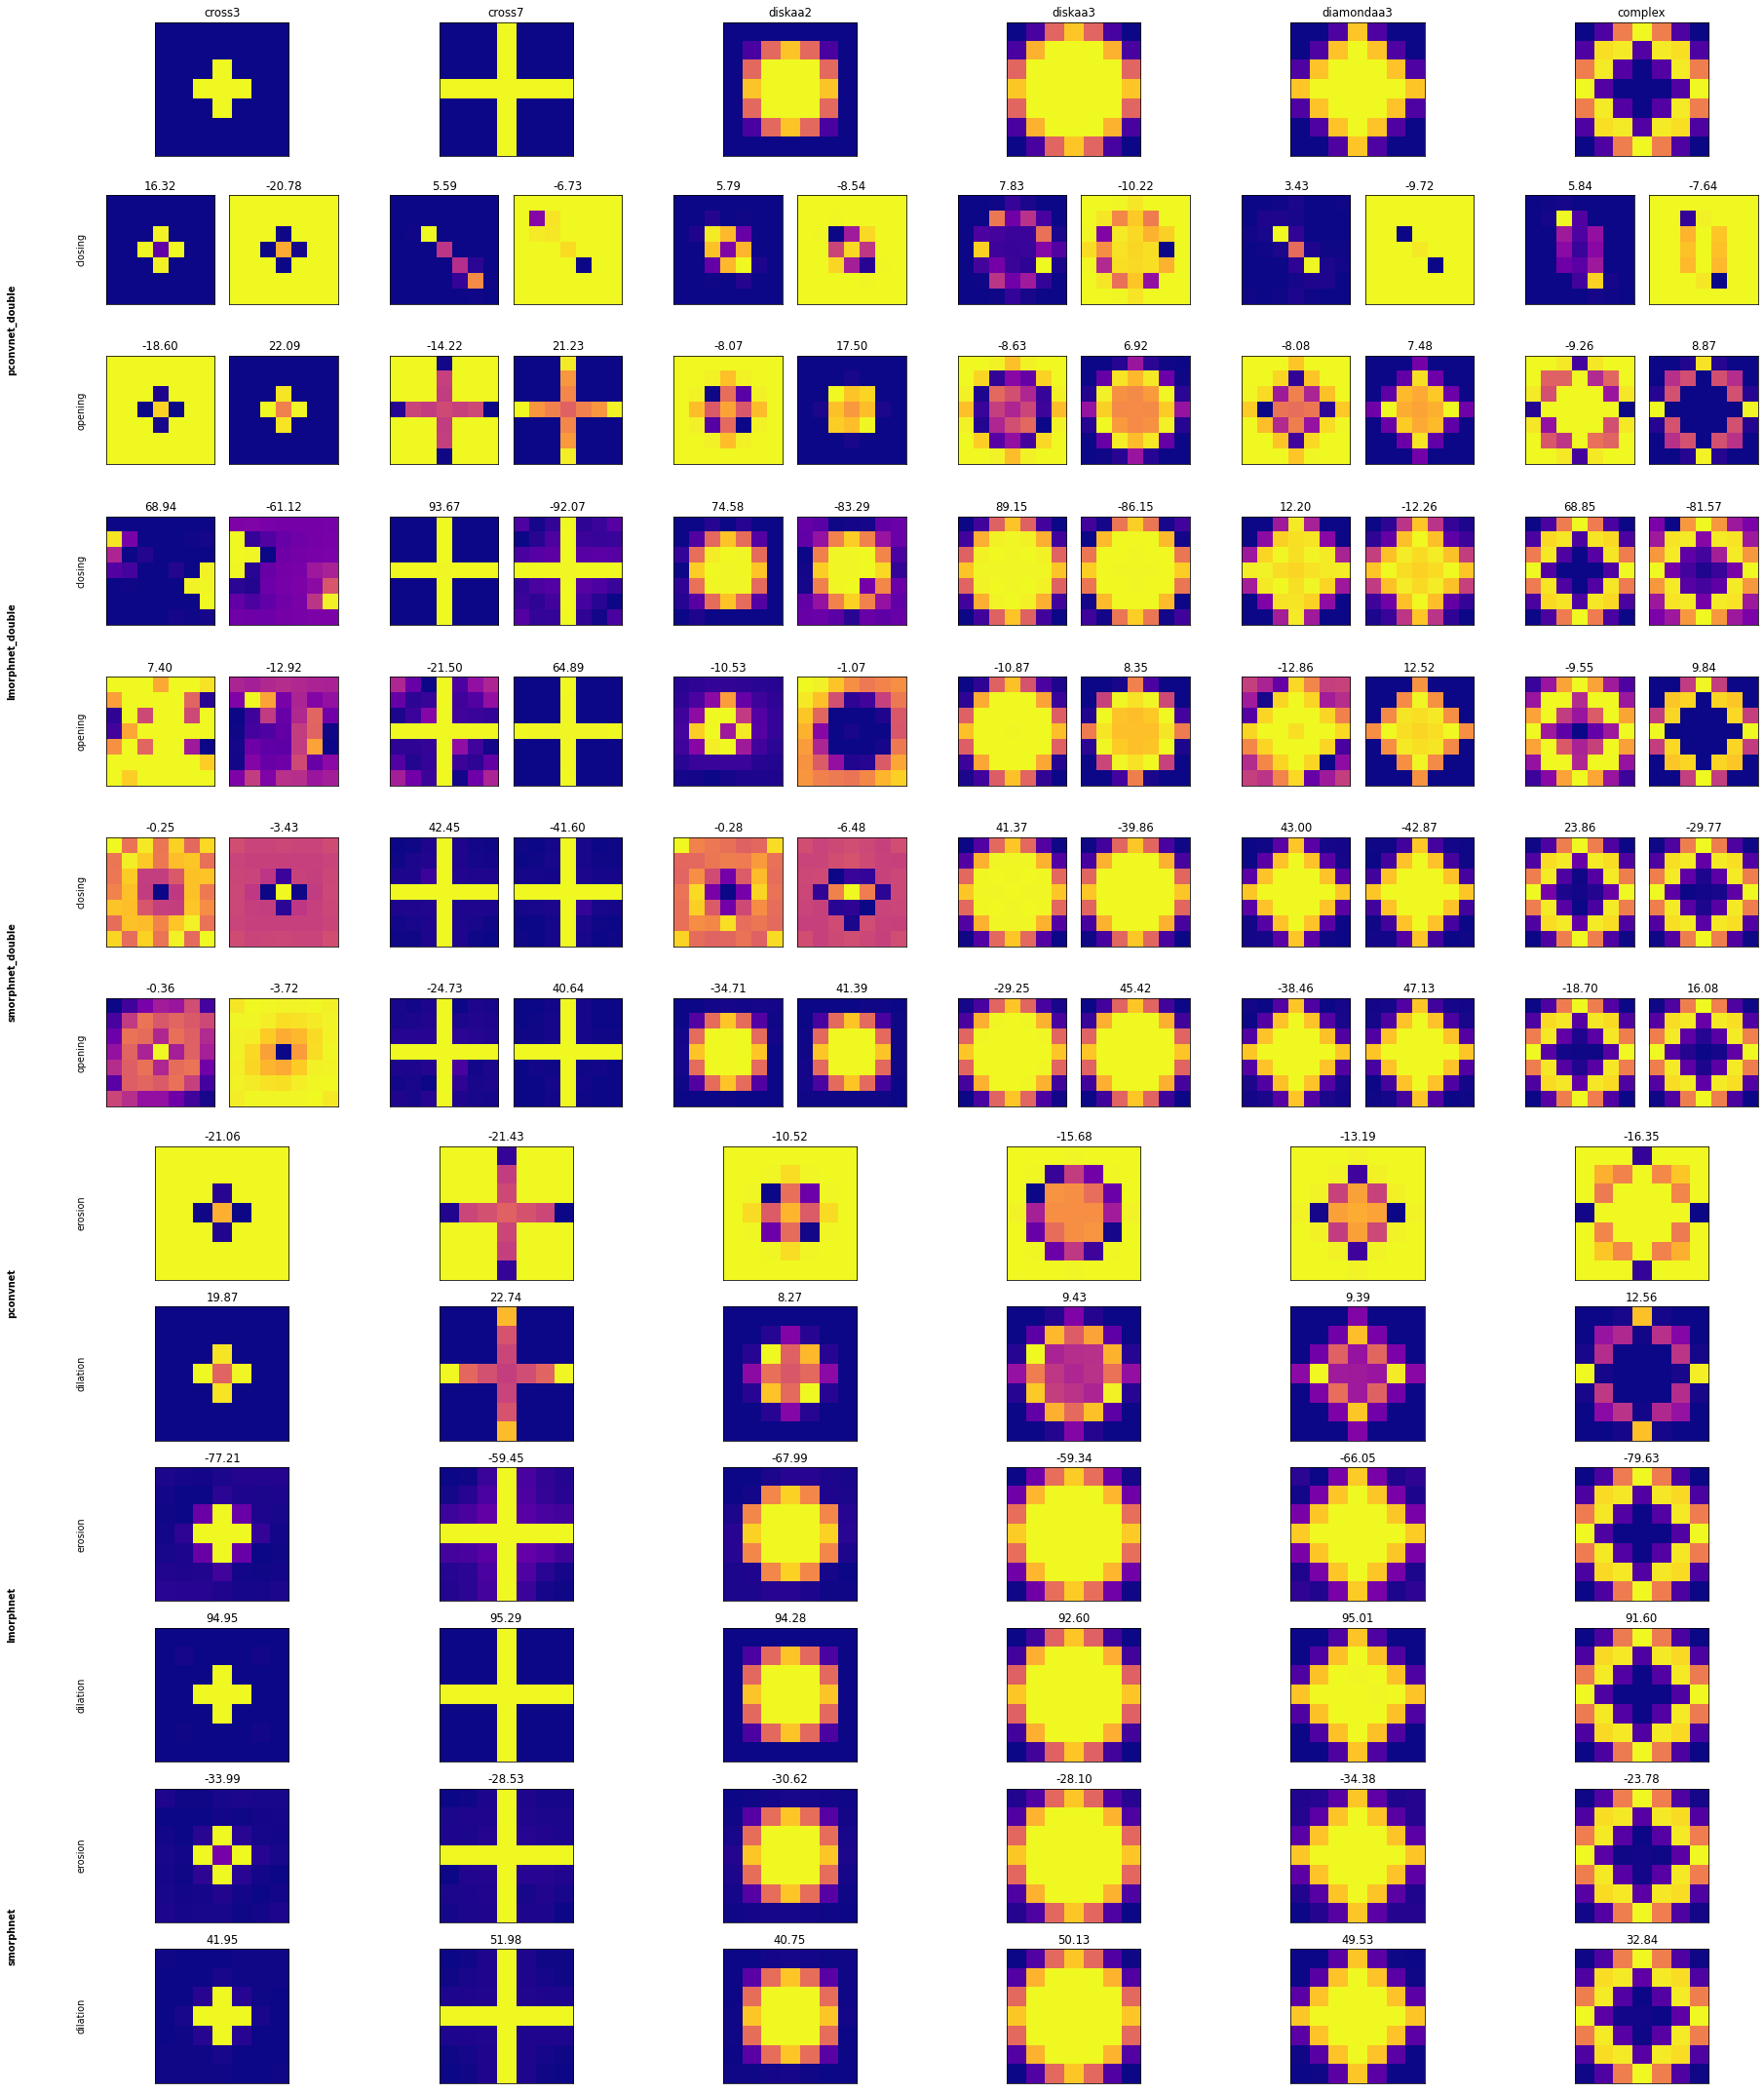

In [81]:
# Creating the global grid
fig = plt.figure(constrained_layout=False, figsize=(1 + len(dnets) * len(dop) + len(snets) * len(sop),
                                                   2 * (n_padding_column + len(selems) * global_column_size)),
                                            dpi=70)
grid = fig.add_gridspec(nrows=1 + len(dnets) * len(dop) + len(snets) * len(sop),
                        ncols=n_padding_column + len(selems) * global_column_size,
                        width_ratios=width_ratios,
                        left=0, right=2)

# Filling selem row
for i, sel_image in enumerate(selems):
    left_border = n_padding_column + i * global_column_size
    right_border = left_border + max_n_filter
    fig.add_subplot(grid[0, left_border:right_border], **plot_params)
    plt.imshow(image.imread(f"out/selems/{sel_image}.png"))
    plt.title(sel_image)

row = 1
params = { "grid": grid,
           "fig": fig,
           "row": row}
    
for n_filters, net_list in nets.items():
    params["n_filters"] = n_filters
    for net in net_list:     
        fig.add_subplot(grid[row:row + len(ops[n_filters].keys()), 0],
                        frameon=False,
                        **plot_params)
        plt.ylabel(net, fontweight='bold')

        for op in ops[n_filters].keys():
            params["op"] = op
            fig.add_subplot(grid[row:row + 1, 1], frameon=False, **plot_params)
            plt.ylabel(op)
            for sel_idx, sel in enumerate(selems):
                path = f"out/mnist_{net}_mse_{op}_{sel}_{run}"
                n_batches = len(os.listdir(f"{path}/vis/batches/"))

                #print_meta(path)

                with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
                    net_plots[net](layers=file['layers'], sel_idx=sel_idx, **params)

                for i in range(n_batches):
                    continue
                    with h5py.File(f"{path}/vis/batches/{i:06}.h5", "r") as file:
                        continue

            row += 1
            params["row"] = row

plt.show()

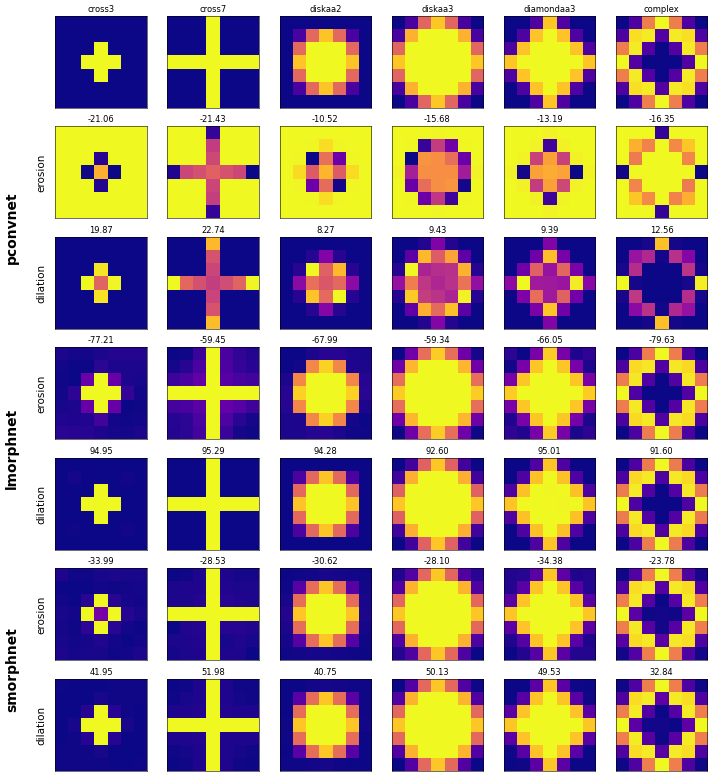

In [87]:
# Creating the global grid
fig = plt.figure(constrained_layout=False, figsize=(1 + len(snets) * len(ops[1].keys()),
                                                   n_padding_column + len(selems) * global_column_size),
                                                   dpi=50)
grid = fig.add_gridspec(nrows=1 + len(snets) * len(sop),
                        ncols=n_padding_column + len(selems) * global_column_size,
                        width_ratios=width_ratios,
                        left=0, right=2)

# Filling selem row
for i, sel_image in enumerate(selems):
    left_border = n_padding_column + i * global_column_size
    right_border = left_border + max_n_filter
    fig.add_subplot(grid[0, left_border:right_border], **plot_params)
    plt.imshow(image.imread(f"out/selems/{sel_image}.png"))
    plt.title(sel_image)

row = 1
params = { "grid": grid,
           "fig": fig,
           "row": row}

params["n_filters"] = 1
for net in snets:     
    fig.add_subplot(grid[row:row + len(ops[1].keys()), 0],
                    frameon=False,
                    **plot_params)
    plt.ylabel(net, fontweight='bold', fontsize=20)

    for op in ops[n_filters].keys():
        params["op"] = op
        fig.add_subplot(grid[row:row + 1, 1], frameon=False, **plot_params)
        plt.ylabel(op, fontsize=15)
        for sel_idx, sel in enumerate(selems):
            path = f"out/mnist_{net}_mse_{op}_{sel}_{run}"
            n_batches = len(os.listdir(f"{path}/vis/batches/"))

            #print_meta(path)

            with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
                net_plots[net](layers=file['layers'], sel_idx=sel_idx, **params)

            for i in range(n_batches):
                continue
                with h5py.File(f"{path}/vis/batches/{i:06}.h5", "r") as file:
                    continue

        row += 1
        params["row"] = row

plt.show()

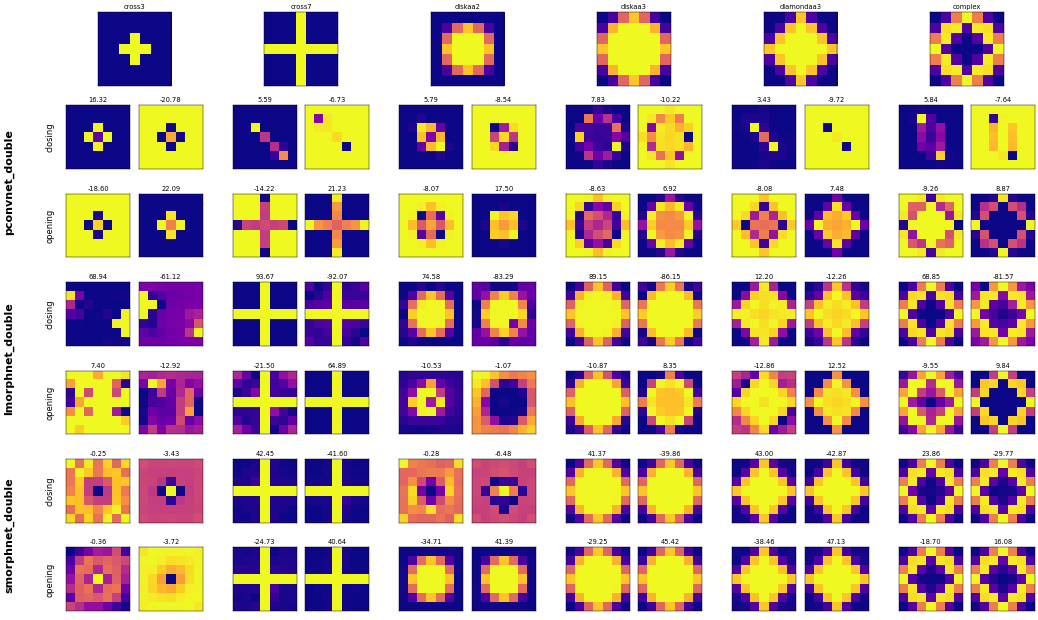

In [106]:
# Creating the global grid
fig = plt.figure(constrained_layout=False, figsize=(1 + 2 * (len(dnets) * len(ops[2].keys())),
                                                    n_padding_column + len(selems) * global_column_size), dpi=40)
grid = fig.add_gridspec(nrows=1 + len(dnets) * len(dop),
                        ncols=n_padding_column + len(selems) * global_column_size,
                        width_ratios=width_ratios,
                        left=0, right=2)

# Filling selem row
for i, sel_image in enumerate(selems):
    left_border = n_padding_column + i * global_column_size
    right_border = left_border + max_n_filter
    fig.add_subplot(grid[0, left_border:right_border], **plot_params)
    plt.imshow(image.imread(f"out/selems/{sel_image}.png"))
    plt.title(sel_image)

row = 1
params = { "grid": grid,
           "fig": fig,
           "row": row}

params["n_filters"] = 2
for net in dnets:     
    fig.add_subplot(grid[row:row + len(ops[2].keys()), 0],
                    frameon=False,
                    **plot_params)
    plt.ylabel(net, fontweight='bold', fontsize=20)

    for op in ops[2].keys():
        params["op"] = op
        fig.add_subplot(grid[row:row + 1, 1], frameon=False, **plot_params)
        plt.ylabel(op, fontsize=15)
        for sel_idx, sel in enumerate(selems):
            path = f"out/mnist_{net}_mse_{op}_{sel}_{run}"
            n_batches = len(os.listdir(f"{path}/vis/batches/"))

            #print_meta(path)

            with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
                net_plots[net](layers=file['layers'], sel_idx=sel_idx, **params)

            for i in range(n_batches):
                continue
                with h5py.File(f"{path}/vis/batches/{i:06}.h5", "r") as file:
                    continue

        row += 1
        params["row"] = row

plt.show()